In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import my_functions
%load_ext autoreload
%autoreload 2

## Carga de metadata de negocios

La información relativa a los negocios se encuentra dividida en archivos de tipo JSON, en la carpeta 'metadata-sitios' de el repositorio del proyecto.

Comenzaremos por unificar esta información y cargarla en un Dataframe que denominaremos 'df_metadata'.

In [2]:
# Ruta de la carpeta que contiene los archivos JSON:
carpeta = r"Datasets/Google Maps/metadata-sitios"

# Obtenemos la lista de archivos en la carpeta:
archivos = os.listdir(carpeta)

# Lista para almacenar los DataFrames de los JSON individuales:
dataframes = []

# Iteramos sobre los archivos:
for archivo in archivos:

    # Verificamos si el archivo es un archivo JSON:
    if archivo.endswith(".json"):

        # Construimos la ruta completa al archivo:
        ruta_completa = os.path.join(carpeta, archivo)
        
        # Cargamos el archivo JSON como DataFrame:
        df = pd.read_json(ruta_completa, lines=True)
        
        # Agregamos el DataFrame a la lista:
        dataframes.append(df)

# Concatenamos todos los DataFrames en uno solo:
df_metadata = pd.concat(dataframes, ignore_index=True)

Se verifica la carga de los datos visualizando un registro.

In [3]:
df_metadata.head(1)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Porter Pharmacy,"Porter Pharmacy, 129 N Second St, Cochran, GA ...",0x88f16e41928ff687:0x883dad4fd048e8f8,None,32.3883,-83.3571,[Pharmacy],4.9,16,None,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...


## Exportación de metadata unificada

Antes de proseguir con la exploración del dataset, exportamos a un achivo tipo Parquet la información obtenida de los archivos JSON originales.

In [4]:
# Exportar df_reviews a Parquet
df_metadata.to_parquet('Datasets/Google Maps/metadata-sitios/metadata_sitios_raw.parquet', index=False)

## Descripción general del dataset

El dataset cuenta con los siguientes campos:

- name: tipo object, nombre del negocio.
- address: tipo object, dirección del negocio.
- gmap_id: tipo object, ID del negocio.
- description: tipo object, descrición del negocio.
- latitude: tipo float64, latitud del negocio.
- longitude: tipo float64, longitud del negocio.
- category: tipo object, categoría del negocio.
- avg_rating: tipo float64, calificación promedio del negocio del 1(peor) al 5(mejor).
- num_of_reviews: tipo int64, cantidad de reseñas.
- price: tipo object, rango de precios del negocio: $ (barato), $$ (moderado), $$$ (caro), $$$$ (muy caro).
- hours: tipo object, horario de apertura.
- MISC: tipo object, diversa información sobre el negocio (opciones de servicio, salud y seguridad, accesibilidad, planificación, métodos de pago).
- state: tipo object, estatus actual del negocio: abierto, cerrado, permanentemente cerrado, etc.
- relative_results: tipo object, negocios similares recomendados por Google.
- url: tipo object, URL de la ubicación del negocio en Google Maps.

In [5]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025011 entries, 0 to 3025010
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   name              object 
 1   address           object 
 2   gmap_id           object 
 3   description       object 
 4   latitude          float64
 5   longitude         float64
 6   category          object 
 7   avg_rating        float64
 8   num_of_reviews    int64  
 9   price             object 
 10  hours             object 
 11  MISC              object 
 12  state             object 
 13  relative_results  object 
 14  url               object 
dtypes: float64(3), int64(1), object(11)
memory usage: 346.2+ MB


Se modificaran a tipo string los campos 'category', 'MISC', 'hours' y 'relative_results' para facilitar el procesamiento.

In [6]:
# Modificar columnas a tipo string
df_metadata['category'] = df_metadata['category'].astype('string')
df_metadata['MISC'] = df_metadata['MISC'].astype('string')
df_metadata['hours'] = df_metadata['hours'].astype('string')
df_metadata['relative_results'] = df_metadata['relative_results'].astype('string')

Se verifica que los tipos de datos se hayan modificado exitosamente.

In [7]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025011 entries, 0 to 3025010
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   name              object 
 1   address           object 
 2   gmap_id           object 
 3   description       object 
 4   latitude          float64
 5   longitude         float64
 6   category          string 
 7   avg_rating        float64
 8   num_of_reviews    int64  
 9   price             object 
 10  hours             string 
 11  MISC              string 
 12  state             object 
 13  relative_results  string 
 14  url               object 
dtypes: float64(3), int64(1), object(7), string(4)
memory usage: 346.2+ MB


## Registros duplicados

In [8]:
my_functions.duplicados(df_metadata)

Cantidad de registros duplicados:  53156


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
22420,"""CCR"" Customizing & Collision Repair","""CCR"" Customizing & Collision Repair, 10093 S ...",0x8639800dfabb15d3:0x8810c2d42d4af7ff,None,30.719908,-93.824819,['Auto body shop'],4.6,6,None,"[['Wednesday', '7:30AM–4:30PM'], ['Thursday', ...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 7:30AM,"['0x86396550f53bf9d1:0x9b0e5f72df8acc84', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
48993,"""CCR"" Customizing & Collision Repair","""CCR"" Customizing & Collision Repair, 10093 S ...",0x8639800dfabb15d3:0x8810c2d42d4af7ff,None,30.719908,-93.824819,['Auto body shop'],4.6,6,None,"[['Wednesday', '7:30AM–4:30PM'], ['Thursday', ...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 7:30AM,"['0x86396550f53bf9d1:0x9b0e5f72df8acc84', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
25379,#1 Cochran Automotive Group,"#1 Cochran Automotive Group, 4514 William Penn...",0x8834ea0c23990217:0xafd7840e5e2becbb,None,40.437498,-79.747017,"['Car dealer', 'Auto body shop', 'Auto machine...",3.4,16,None,"[['Tuesday', '7:30AM–6PM'], ['Wednesday', '7:3...","{'Service options': ['In-store shopping'], 'Ac...",Closed ⋅ Opens 7:30AM Wed,"['0x8834c191bc1dddd3:0x2632b5f067f7fc95', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
51952,#1 Cochran Automotive Group,"#1 Cochran Automotive Group, 4514 William Penn...",0x8834ea0c23990217:0xafd7840e5e2becbb,None,40.437498,-79.747017,"['Car dealer', 'Auto body shop', 'Auto machine...",3.4,16,None,"[['Tuesday', '7:30AM–6PM'], ['Wednesday', '7:3...","{'Service options': ['In-store shopping'], 'Ac...",Closed ⋅ Opens 7:30AM Wed,"['0x8834c191bc1dddd3:0x2632b5f067f7fc95', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
19613,#1 Nail Care,"#1 Nail Care, 462 Railroad St, St Johnsbury, V...",0x4cb446250216c523:0x854bda8ff2000309,None,44.419161,-72.015329,['Nail salon'],4.2,58,None,"[['Wednesday', '9AM–7PM'], ['Thursday', '9AM–7...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 9AM,"['0x4cb446243e843a51:0x7f1b9792b325e955', '0x4...",https://www.google.com/maps/place//data=!4m2!3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30570,网邮速递休斯顿门店,"〒77036 Texas, Houston, Bellaire Blvd, 网邮速递休斯顿门店",0x8640c2c4545c6647:0x3a67b58151a39c3d,None,29.704559,-95.548411,['Shopping mall'],3.7,3,None,"[['Wednesday', '10AM–6:30PM'], ['Thursday', '1...",<NA>,Permanently closed,<NA>,https://www.google.com/maps/place//data=!4m2!3...
9659,诺亚方舟剧本杀推理社,"诺亚方舟剧本杀推理社, 3064 Whitestone Expy 2 FL, Queens,...",0x89c261e036195025:0x6334440870e49468,None,40.769553,-73.837235,['Entertainment agency'],4.5,14,None,"[['Wednesday', '11AM–10PM'], ['Thursday', '11A...","{'Service options': ['Onsite services', 'Onlin...",Open ⋅ Closes 10PM,<NA>,https://www.google.com/maps/place//data=!4m2!3...
36232,诺亚方舟剧本杀推理社,"诺亚方舟剧本杀推理社, 3064 Whitestone Expy 2 FL, Queens,...",0x89c261e036195025:0x6334440870e49468,None,40.769553,-73.837235,['Entertainment agency'],4.5,14,None,"[['Wednesday', '11AM–10PM'], ['Thursday', '11A...","{'Service options': ['Onsite services', 'Onlin...",Open ⋅ Closes 10PM,<NA>,https://www.google.com/maps/place//data=!4m2!3...
17337,🏆 Premier Pool Service | Coachella Valley,None,0x80daf725be5d10f9:0x3a3df0f782d352d4,None,33.771632,-116.381610,"['Swimming pool repair service', 'Service esta...",5.0,14,None,"[['Wednesday', '9AM–5PM'], ['Thursday', '9AM–5...",<NA>,Closed ⋅ Opens 9AM,"['0x80daf757393a36fb:0x5f1b4d636ed0197f', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


Se observa que hay 53156 registross duplicados, por lo que se procede a eliminarlos quedando un único registro de cada uno.

In [9]:
# Eliminamos los duplicados:
print(f"Cantidad de registros: {len(df_metadata)}")
df_metadata.drop_duplicates(inplace=True)
print(f"Cantidad de registros luego del filtro: {len(df_metadata)}")

Cantidad de registros: 3025011
Cantidad de registros luego del filtro: 2998428


## Exploración de campo 'category'

A continuación se realiza una exploración del campo 'category', el cual contiene información de la categoría del negocio, con el objetivo de identificar establecimientos de la industria gastronómica.

La siguiente función devuelve registros al azar de este campo. 

In [10]:
my_functions.registros_al_azar(df_metadata['category'], 20)

2806173                ['Electric vehicle charging station']
1493882    ['Attorney', 'Estate planning attorney', 'Lega...
2113831                                  ['Eye care center']
2056935                     ['Winery', 'Tourist attraction']
1231179    ['Appliance repair service', 'Service establis...
160305                   ['Business administration service']
1643410                                    ['Tour operator']
853614                     ['Agricultural service', 'Store']
2638199    ['Reformed church', 'Christian church', 'Churc...
1730110                                     ['Home builder']
1149703                                   ['Parking garage']
2274284    ['Recycling center', 'Bottle & can redemption ...
1170606                                           ['Church']
2361579                                    ['Antique store']
3013227    ['Self-storage facility', 'Moving and storage ...
528454     ['Coworking space', 'Art studio', 'Business ce...
1167408    ['Chiropracto

Se observan registros que se asemejan a la estructura de una lista, aunque presenta problemas de formato. Se procede a realizar una limpieza.

Para empezar, dado que el campo contiene algunos valores nulos, se completarán como vacíos momentáneamente.

In [11]:
my_functions.describir_df(df_metadata, campos_incluir = ['category'])

Cantidad Registros:  2998428
Cantidad Campos:  1
Campos:
 Index(['category'], dtype='object')


,Campo,Tipo de Dato,Valores Nulos,% Nulos,Valores No Nulos,% No Nulos,Valores Únicos,% Únicos
0,category,"[<class 'str'>, <class 'pandas._libs.missing.N...",17183,0.57,2981245,99.43,356100,11.88


In [12]:
# Ejemplo de valor nulo 
df_metadata['category'][2828500]

<NA>

In [17]:
# Llenar valores nulos con cadena vacía
df_metadata['category'] = df_metadata['category'].fillna('')

Se verifica con el ejemplo visualizado que se reemplazó el valor nulo por una cadena de texto vacía.

In [18]:
# Ejemplo de valor nulo 
df_metadata['category'][2828500]

''

In [19]:
my_functions.describir_df(df_metadata, campos_incluir = ['category'])

Cantidad Registros:  2998428
Cantidad Campos:  1
Campos:
 Index(['category'], dtype='object')


,Campo,Tipo de Dato,Valores Nulos,% Nulos,Valores No Nulos,% No Nulos,Valores Únicos,% Únicos
0,category,[<class 'str'>],0,0.0,2998428,100.0,356101,11.88


A continuación se procede a limpiar el texto, separando con comas los distintos valores de categorías, removiendo corchetes y comillas.

Estos nuevos valores se generarán en un nuevo campo, 'categories', en el cual se copiará la información de 'category' para luego realizar las modificaciones mencionadas.

In [20]:
# Se crea el campo 'categories' copiando la información de 'category'
df_metadata['categories'] = df_metadata['category']
df_metadata['categories'] = df_metadata['categories'].astype('string')

my_functions.registros_al_azar(df_metadata[['category', 'categories']], 2)

,category,categories
2175231,['Landscaper'],['Landscaper']
343054,['Medical Center'],['Medical Center']


In [21]:
# Eliminación de corchetes
df_metadata['categories'] = df_metadata['categories'].str.replace("[", "")
df_metadata['categories'] = df_metadata['categories'].str.replace("]", "")

# Función para agregar comas entre categorías
def agregar_comas(cadena):
  """
  Agrega comas entre valores entre comillas en una cadena de texto.

  Parámetros:
    cadena: La cadena de texto a procesar.

  Retorno:
    La cadena de texto con las comas añadidas.
  """
  # Busca valores entre comillas.
  valores = re.findall(r"'(.*?)'", cadena)

  # Si hay solo un valor, retorna la cadena original.
  if len(valores) <= 1:
    return cadena

  # Une los valores con comas y espacios.
  cadena_con_comas = ", ".join(valores)

  # Retorna la cadena con las comas añadidas.
  return cadena_con_comas

# Se ejecuta función para agregar comas
df_metadata['categories'] = df_metadata['categories'].apply(agregar_comas)

# Se eliminan comillas
df_metadata['categories'] = df_metadata['categories'].str.replace("'", "")

# Se eliminan comillas
df_metadata['categories'] = df_metadata['categories'].str.replace('"', '')

Se verifican las modificaciones.

In [22]:
my_functions.registros_al_azar(df_metadata[['category', 'categories']], 2)

,category,categories
523029,"['Oncologist', 'Obstetrician-gynecologist']","Oncologist, Obstetrician-gynecologist"
539947,['Home goods store'],Home goods store


Como se puede observar, las modificaciones se realizaron exitosamente.


In [23]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2998428 entries, 0 to 3025010
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   name              object 
 1   address           object 
 2   gmap_id           object 
 3   description       object 
 4   latitude          float64
 5   longitude         float64
 6   category          string 
 7   avg_rating        float64
 8   num_of_reviews    int64  
 9   price             object 
 10  hours             string 
 11  MISC              string 
 12  state             object 
 13  relative_results  string 
 14  url               object 
 15  categories        object 
dtypes: float64(3), int64(1), object(8), string(4)
memory usage: 388.9+ MB



Habiendo realizado estos pasos se continúa con la exploración de los valores de categorías.

En primera instancia se realiza un conteo de valores y un gráfico de nube de palabras.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


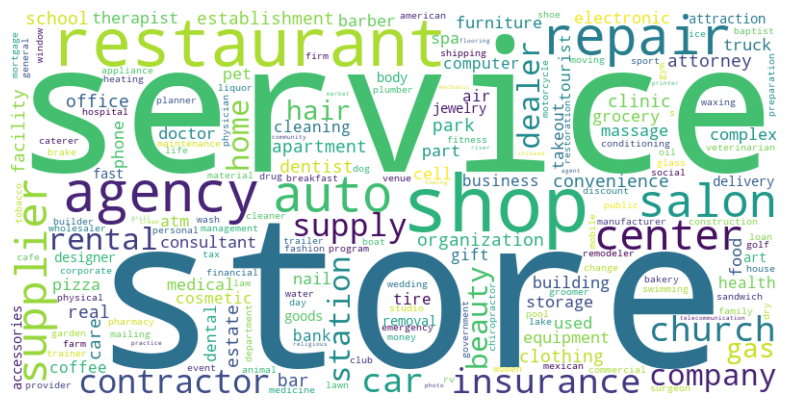

In [24]:
# Se realizan las importaciones necesarias
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
# Descargamos los recursos necesarios de nltk:
nltk.download('punkt')
nltk.download('stopwords')

# Combinamos todas las categorías en una sola cadena, separadas por comas:
all_categories = ','.join(df_metadata['categories'].str.lower())

# Tokenizamos las palabras y eliminamos las stopwords:
stop_words = set(stopwords.words('spanish'))
tokens = [word for word in word_tokenize(all_categories) if word.isalpha() and word not in stop_words]

# Contamos la frecuencia de cada palabra:
word_freq = Counter(tokens)

# Filtramos las collocations en la tabla de frecuencias:
filtered_word_freq = {word: freq for word, freq in word_freq.items() if freq > 1}

# Convertimos el resultado en un DataFrame para visualización:
word_freq_df = pd.DataFrame(list(filtered_word_freq.items()), columns=['Palabra', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

# Creamos la nube de palabras:
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Se observan los 20 términos más repetidos en el campo 'categories'.

In [25]:
word_freq_df.head(20)

,Palabra,Frecuencia
6,store,958119
12,service,670226
18,shop,520891
4,restaurant,372010
71,agency,240095
81,repair,224144
24,auto,202765
8,salon,168058
97,supplier,149637
156,center,140805


El término 'restaurants' es el cuarto en frecuencia de apariciones dentro del campo. Entre los primeros 20 registros es el único vinculado a la gastronomía. En la nube de palabras se observan otros términos asociados más específicos.

Se toma 'restaurants' como palabra clave para realizar el filtrado de la información pertinente para focalizar y profundizar el análisis.

### Filtrado por categoría 'Restaurants'

En este punto se crea un nuevo dataset que contendrá únicamente registros que contengan la palabra clave 'restaurants'.

El mismo se almacenará en un archivo de tipo Parquet y se analizará en el siguiente notebook "1.3_ETL_restaurants".

In [26]:
# Filtramos los registros que contienen la categoría "restaurant":
df_restaurants = df_metadata[df_metadata['categories'].str.contains("restaurant", case=False)].reset_index(drop=True)

print("Registros de df_restaurants: ", len(df_restaurants))

Registros de df_restaurants:  210876


In [27]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              210876 non-null  object 
 1   address           209823 non-null  object 
 2   gmap_id           210876 non-null  object 
 3   description       72167 non-null   object 
 4   latitude          210876 non-null  float64
 5   longitude         210876 non-null  float64
 6   category          210876 non-null  string 
 7   avg_rating        210876 non-null  float64
 8   num_of_reviews    210876 non-null  int64  
 9   price             99724 non-null   object 
 10  hours             188942 non-null  string 
 11  MISC              209475 non-null  string 
 12  state             189777 non-null  object 
 13  relative_results  170206 non-null  string 
 14  url               210876 non-null  object 
 15  categories        210876 non-null  object 
dtypes: float64(3), int64

Se visualizan algunos registros donde se puede observar que todos contienen 'restaurants' dentro de los valores de 'categories'.

In [28]:
my_functions.registros_al_azar(df_restaurants['categories'], 10)

184730    Fast food restaurant, Chicken restaurant, Hamb...
95079     Chinese restaurant, Asian restaurant, Delivery...
59102                 Vietnamese restaurant, Pho restaurant
153255    Sushi restaurant, Japanese restaurant, Meal de...
37387     Health food restaurant, Health food store, Jui...
124057             New American restaurant, Bar, Restaurant
174212    Italian restaurant, Caterer, Family restaurant...
64213     Chinese restaurant, Asian restaurant, Delivery...
97211         Restaurant, Coffee shop, Wi-Fi spot, Wine bar
92857                                   American restaurant
Name: categories, dtype: object

# Exploracion 'category'

In [29]:
df_restaurants['categories'][3]
# Mostrar los 10 registros seleccionados
categorias = df_restaurants['categories']

# Explode las categorías seleccionadas para mostrar cada una en una fila separada
categorias = categorias.str.split(',').explode()

categorias = categorias.unique()

print(len(categorias))
categorias

2607


array(['Korean restaurant', 'Restaurant', 'Bakery', ..., 'Fishing store',
       ' Water ski shop', 'Bridge'], dtype=object)

## Creación de dataframe auxiliar

Por último, se crean un dataframe auxiliar, 'df_id_restaurant', que contendrá los identificadores únicos ('gmap_id') que corresponden a los registros filtrados en 'df_restaurants'.

Esta información será utilizada en el proceso de ETL de reseñas.

In [32]:
df_id_restaurant = df_restaurants[['gmap_id']].copy()

df_id_restaurant.head()

,gmap_id
0,0x80c2c778e3b73d33:0xbdc58662a4a97d49
1,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42
2,0x87ec235c54d25b31:0x3b75fb5facc602f
3,0x89c6c89efcaed69d:0xded973f6033e7dba
4,0x7c00456eecad3111:0x8217f9600c51f33


In [33]:
df_id_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   gmap_id  210876 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


In [34]:
df_id_restaurant['gmap_id'] = df_id_restaurant['gmap_id'].astype('string')

In [35]:
df_id_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   gmap_id  210876 non-null  string
dtypes: string(1)
memory usage: 1.6 MB


In [36]:
# Exportar a formato Parquet
df_id_restaurant.to_parquet('Datasets/Google Maps/1_metadata_restaurants/df_id_restaurant.parquet', index=False)

Tomando estos identificadores se filtrarán las reseñas que corresponden a estos negocios en el análisis que se realizará en el siguiente notebook "1.2_ETL_reviews".

## Exportar a archivo

Se almacena esta información en el archivo 'metadata_restaurants_v1.parquet' y se reserva para continuar el análisis el próximas etapas del proyecto.

In [37]:
# Nombre de la carpeta a crear
nombre_carpeta = "1_metadata_restaurants"

# Ruta relativa de la carpeta
ruta_carpeta = os.path.join("Datasets", "Google Maps", nombre_carpeta)

# Verificar si la carpeta no existe y crearla si es necesario
if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)
    print(f"Carpeta '{ruta_carpeta}' creada correctamente.")
else:
    print(f"La carpeta '{ruta_carpeta}' ya existe.")
    
# Exportar a formato Parquet
df_restaurants.to_parquet('Datasets/Google Maps/1_metadata_restaurants/metadata_restaurants_v1.parquet', index=False)

La carpeta 'Datasets\Google Maps\1_metadata_restaurants' ya existe.
